# Feature Engineering - Selección de Features para ML Detector

**Objetivo**: Seleccionar las 23 features más importantes para el detector Level 1

## Arquitectura Tricapa:
- **Level 1**: 23 features (detección general)
- **Level 2**: 82 features (especialización DDoS/Ransomware)
- **Level 3**: 4 features (anomalías tráfico interno/web)

## Dataset: CIC-IDS-2017
- Total: 2.8M flows
- Features disponibles: 79
- Clases: BENIGN + 7 tipos de ataques

In [1]:
# Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import warnings
warnings.filterwarnings('ignore')

# Configuración
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✅ Imports completados")

✅ Imports completados


## 1. Cargar Datos con Ataques

In [2]:
# Cargar múltiples archivos para tener BENIGN + Ataques
ids_path = Path("../datasets/CIC-IDS-2017/MachineLearningCVE")

# Seleccionar archivos con diversidad de ataques
files_to_load = [
    "Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv",      # DDoS
    "Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv",  # PortScan
    "Tuesday-WorkingHours.pcap_ISCX.csv",                    # Varios ataques
    "Monday-WorkingHours.pcap_ISCX.csv",                     # BENIGN
]

print("Cargando datasets...")
dfs = []

for filename in files_to_load:
    filepath = ids_path / filename
    if filepath.exists():
        print(f"  Cargando {filename}...")
        df = pd.read_csv(filepath, encoding='latin-1')
        dfs.append(df)
        print(f"    Loaded: {df.shape[0]:,} rows, Labels: {df[' Label'].unique()}")
    else:
        print(f"  ⚠️ No encontrado: {filename}")

# Concatenar todos
df_full = pd.concat(dfs, ignore_index=True)
print(f"\n✅ Dataset completo: {df_full.shape[0]:,} flows, {df_full.shape[1]} features")

# Ver distribución de labels
print("\n📊 Distribución de Labels:")
label_dist = df_full[' Label'].value_counts()
for label, count in label_dist.items():
    pct = count / len(df_full) * 100
    print(f"  {label:30s}: {count:>10,} ({pct:>6.2f}%)")

Cargando datasets...
  Cargando Friday-WorkingHours-Afternoon-DDos.pcap_ISCX.csv...
    Loaded: 225,745 rows, Labels: ['BENIGN' 'DDoS']
  Cargando Friday-WorkingHours-Afternoon-PortScan.pcap_ISCX.csv...
    Loaded: 286,467 rows, Labels: ['BENIGN' 'PortScan']
  Cargando Tuesday-WorkingHours.pcap_ISCX.csv...
    Loaded: 445,909 rows, Labels: ['BENIGN' 'FTP-Patator' 'SSH-Patator']
  Cargando Monday-WorkingHours.pcap_ISCX.csv...
    Loaded: 529,918 rows, Labels: ['BENIGN']

✅ Dataset completo: 1,488,039 flows, 79 features

📊 Distribución de Labels:
  BENIGN                        :  1,187,247 ( 79.79%)
  PortScan                      :    158,930 ( 10.68%)
  DDoS                          :    128,027 (  8.60%)
  FTP-Patator                   :      7,938 (  0.53%)
  SSH-Patator                   :      5,897 (  0.40%)


## 2. Limpieza de Datos

In [3]:
print("🧹 Limpiando datos...\n")

# Separar features y label
label_col = ' Label'
X = df_full.drop(columns=[label_col])
y = df_full[label_col]

print(f"Features: {X.shape[1]}")
print(f"Labels: {y.nunique()} clases únicas")

# 1. Manejar valores infinitos
print("\n1️⃣ Manejando valores infinitos...")
numeric_cols = X.select_dtypes(include=[np.number]).columns

inf_counts_before = np.isinf(X[numeric_cols]).sum().sum()
print(f"   Infinitos antes: {inf_counts_before:,}")

# Reemplazar inf por NaN, luego rellenar con el máximo finito
X[numeric_cols] = X[numeric_cols].replace([np.inf, -np.inf], np.nan)

# Rellenar NaN con la mediana de cada columna
for col in numeric_cols:
    if X[col].isnull().any():
        median_val = X[col].median()
        X[col].fillna(median_val, inplace=True)

inf_counts_after = np.isinf(X[numeric_cols]).sum().sum()
print(f"   Infinitos después: {inf_counts_after:,}")

# 2. Manejar valores nulos
print("\n2️⃣ Manejando valores nulos...")
null_counts_before = X.isnull().sum().sum()
print(f"   Nulos antes: {null_counts_before:,}")

X.fillna(0, inplace=True)

null_counts_after = X.isnull().sum().sum()
print(f"   Nulos después: {null_counts_after:,}")

print("\n✅ Datos limpios")

🧹 Limpiando datos...

Features: 78
Labels: 5 clases únicas

1️⃣ Manejando valores infinitos...
   Infinitos antes: 1,928
   Infinitos después: 0

2️⃣ Manejando valores nulos...
   Nulos antes: 0
   Nulos después: 0

✅ Datos limpios


## 3. Convertir Labels a Binary (BENIGN vs ATTACK)

In [4]:
# Para Level 1: Clasificación binaria simple
print("🏷️ Convirtiendo labels a binario...\n")

y_binary = (y != 'BENIGN').astype(int)

print("Distribución binaria:")
print(f"  BENIGN (0): {(y_binary == 0).sum():,} ({(y_binary == 0).sum()/len(y_binary)*100:.2f}%)")
print(f"  ATTACK (1): {(y_binary == 1).sum():,} ({(y_binary == 1).sum()/len(y_binary)*100:.2f}%)")

print("\n✅ Labels convertidas")

🏷️ Convirtiendo labels a binario...

Distribución binaria:
  BENIGN (0): 1,187,247 (79.79%)
  ATTACK (1): 300,792 (20.21%)

✅ Labels convertidas


## 4. Feature Importance con Random Forest

In [5]:
print("🌲 Calculando Feature Importance con Random Forest...\n")

# Split para entrenamiento
X_train, X_test, y_train, y_test = train_test_split(
    X, y_binary, 
    test_size=0.2, 
    random_state=42,
    stratify=y_binary
)

print(f"Train set: {X_train.shape[0]:,} samples")
print(f"Test set:  {X_test.shape[0]:,} samples")

# Entrenar Random Forest (rápido, solo para feature importance)
print("\nEntrenando Random Forest (10 árboles, rápido)...")
rf = RandomForestClassifier(
    n_estimators=10,  # Pocos árboles para rapidez
    max_depth=10,
    random_state=42,
    n_jobs=-1,
    verbose=1
)

rf.fit(X_train, y_train)

# Feature importance
feature_importance = pd.DataFrame({
    'feature': X.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

print("\n✅ Feature importance calculada")
print("\n📊 Top 30 Features:")
print(feature_importance.head(30).to_string(index=False))

🌲 Calculando Feature Importance con Random Forest...

Train set: 1,190,431 samples
Test set:  297,608 samples

Entrenando Random Forest (10 árboles, rápido)...


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 16 concurrent workers.



✅ Feature importance calculada

📊 Top 30 Features:
                     feature  importance
           Packet Length Std    0.092955
           Subflow Fwd Bytes    0.084973
       Fwd Packet Length Max    0.072821
        Avg Fwd Segment Size    0.072734
              ACK Flag Count    0.068203
      Packet Length Variance    0.066051
              PSH Flag Count    0.048799
       Bwd Packet Length Max    0.038545
            act_data_pkt_fwd    0.037492
 Total Length of Fwd Packets    0.033151
       Fwd Packet Length Std    0.030367
               Fwd Packets/s    0.030312
           Subflow Bwd Bytes    0.028882
            Destination Port    0.026495
      Init_Win_bytes_forward    0.023616
         Subflow Fwd Packets    0.021684
                 Fwd IAT Min    0.020950
          Packet Length Mean    0.020700
 Total Length of Bwd Packets    0.019586
      Bwd Packet Length Mean    0.018653
       Bwd Packet Length Min    0.015025
               Flow Duration    0.012409
     

[Parallel(n_jobs=-1)]: Done  10 out of  10 | elapsed:    7.7s finished


## 5. Visualizar Feature Importance

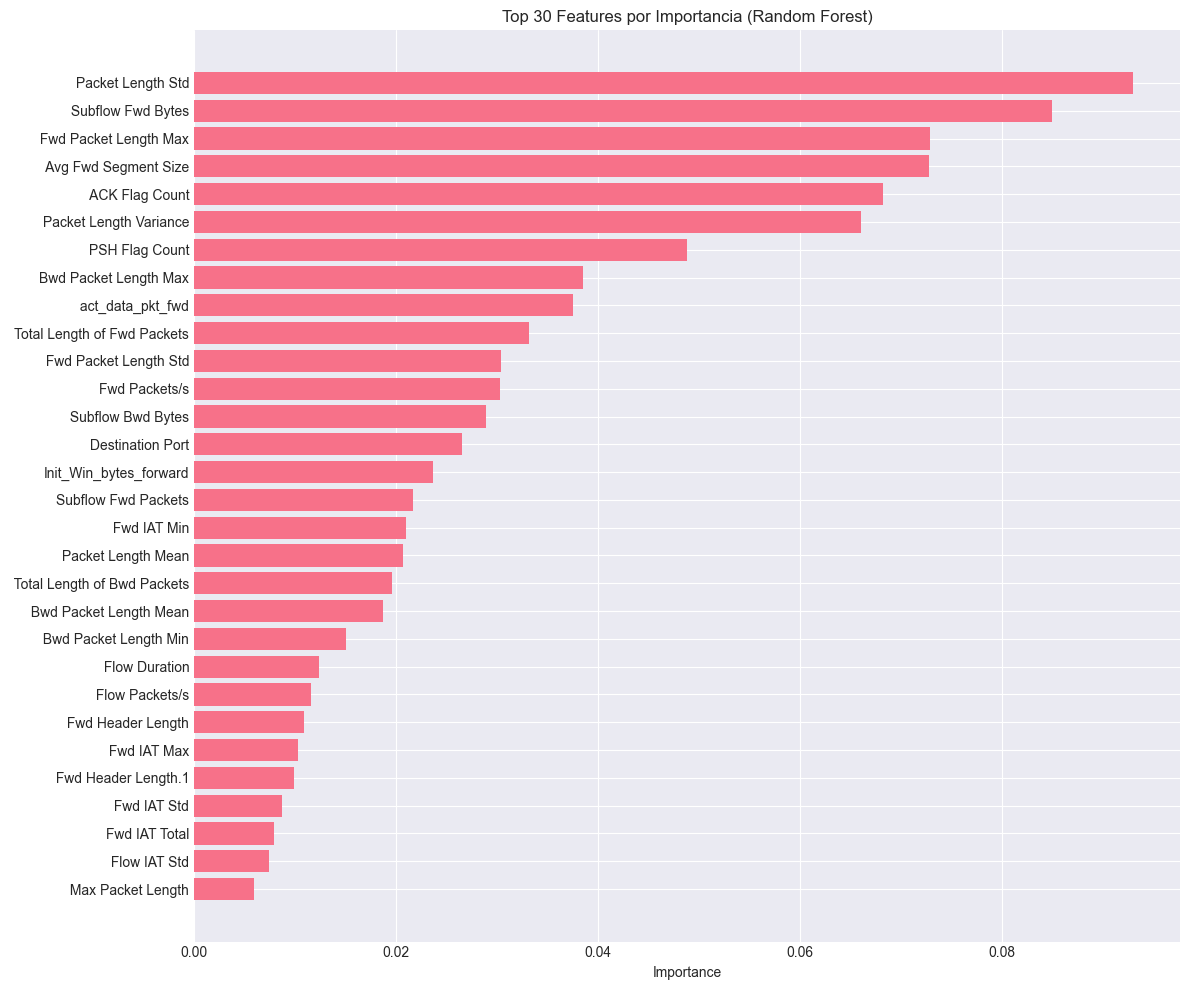

✅ Plot guardado en outputs/plots/feature_importance_top30.png


In [6]:
# Plot top 30 features
plt.figure(figsize=(12, 10))
top_30 = feature_importance.head(30)

plt.barh(range(len(top_30)), top_30['importance'])
plt.yticks(range(len(top_30)), top_30['feature'])
plt.xlabel('Importance')
plt.title('Top 30 Features por Importancia (Random Forest)')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.savefig('../outputs/plots/feature_importance_top30.png', dpi=300, bbox_inches='tight')
plt.show()

print("✅ Plot guardado en outputs/plots/feature_importance_top30.png")

## 6. Seleccionar Top 23 Features para Level 1

In [7]:
# Seleccionar top 23
top_23_features = feature_importance.head(23)['feature'].tolist()

print("🎯 TOP 23 FEATURES SELECCIONADAS PARA LEVEL 1:")
print("="*80)
for i, feat in enumerate(top_23_features, 1):
    importance = feature_importance[feature_importance['feature'] == feat]['importance'].values[0]
    print(f"{i:2d}. {feat:50s} (importance: {importance:.6f})")

print("\n✅ Features seleccionadas para Level 1")

🎯 TOP 23 FEATURES SELECCIONADAS PARA LEVEL 1:
 1.  Packet Length Std                                 (importance: 0.092955)
 2.  Subflow Fwd Bytes                                 (importance: 0.084973)
 3.  Fwd Packet Length Max                             (importance: 0.072821)
 4.  Avg Fwd Segment Size                              (importance: 0.072734)
 5.  ACK Flag Count                                    (importance: 0.068203)
 6.  Packet Length Variance                            (importance: 0.066051)
 7.  PSH Flag Count                                    (importance: 0.048799)
 8. Bwd Packet Length Max                              (importance: 0.038545)
 9.  act_data_pkt_fwd                                  (importance: 0.037492)
10. Total Length of Fwd Packets                        (importance: 0.033151)
11.  Fwd Packet Length Std                             (importance: 0.030367)
12. Fwd Packets/s                                      (importance: 0.030312)
13.  Subflow Bwd B

## 7. Guardar Resultados

In [8]:
import json
from datetime import datetime

# Crear metadata
metadata = {
    "generation_date": datetime.now().isoformat(),
    "dataset": "CIC-IDS-2017",
    "total_features_available": len(X.columns),
    "level1_features_selected": 23,
    "selection_method": "RandomForest Feature Importance",
    "rf_params": {
        "n_estimators": 10,
        "max_depth": 10,
        "random_state": 42
    },
    "level1_features": top_23_features,
    "feature_importance": [
        {
            "feature": row['feature'],
            "importance": float(row['importance'])
        }
        for _, row in feature_importance.head(23).iterrows()
    ]
}

# Guardar JSON
output_path = Path("../outputs/metadata/level1_features_selected.json")
output_path.parent.mkdir(parents=True, exist_ok=True)

with open(output_path, 'w') as f:
    json.dump(metadata, f, indent=2)

print(f"✅ Metadata guardada en: {output_path}")

# También guardar CSV simple
feature_importance.to_csv(
    "../outputs/metadata/all_features_importance.csv",
    index=False
)

print("✅ Importancia completa guardada en: outputs/metadata/all_features_importance.csv")

✅ Metadata guardada en: ../outputs/metadata/level1_features_selected.json
✅ Importancia completa guardada en: outputs/metadata/all_features_importance.csv


## 8. Mapeo a Features del Sniffer-eBPF

In [9]:
# Features del sniffer-ebpf (simplificado)
sniffer_features = [
    'flow_duration',
    'total_forward_packets',
    'total_backward_packets',
    'total_forward_bytes',
    'total_backward_bytes',
    'flow_bytes_per_second',
    'flow_packets_per_second',
    'forward_packet_length_mean',
    'backward_packet_length_mean',
    'syn_flag_count',
    'psh_flag_count',
    'ack_flag_count',
    'rst_flag_count',
    # ... y más
]

print("🔗 Mapeando features CIC → Sniffer-eBPF...\n")

# Mapeo manual de las top 23
# (Esto lo refinamos después viendo los nombres exactos)
mapping = {}

for cic_feat in top_23_features:
    # Normalizar nombre
    normalized = cic_feat.lower().strip().replace(' ', '_')
    
    # Buscar match en sniffer features
    matches = [
        sf for sf in sniffer_features 
        if sf.lower() in normalized or normalized in sf.lower()
    ]
    
    if matches:
        mapping[cic_feat] = matches[0]
        print(f"✓ {cic_feat:50s} → {matches[0]}")
    else:
        mapping[cic_feat] = "NO_MATCH"
        print(f"⚠ {cic_feat:50s} → NO MATCH")

mapped_count = sum(1 for v in mapping.values() if v != "NO_MATCH")
print(f"\n📊 Mapeadas: {mapped_count}/{len(top_23_features)} ({mapped_count/len(top_23_features)*100:.1f}%)")

🔗 Mapeando features CIC → Sniffer-eBPF...

⚠  Packet Length Std                                 → NO MATCH
⚠  Subflow Fwd Bytes                                 → NO MATCH
⚠  Fwd Packet Length Max                             → NO MATCH
⚠  Avg Fwd Segment Size                              → NO MATCH
✓  ACK Flag Count                                    → ack_flag_count
⚠  Packet Length Variance                            → NO MATCH
✓  PSH Flag Count                                    → psh_flag_count
⚠ Bwd Packet Length Max                              → NO MATCH
⚠  act_data_pkt_fwd                                  → NO MATCH
⚠ Total Length of Fwd Packets                        → NO MATCH
⚠  Fwd Packet Length Std                             → NO MATCH
⚠ Fwd Packets/s                                      → NO MATCH
⚠  Subflow Bwd Bytes                                 → NO MATCH
⚠  Destination Port                                  → NO MATCH
⚠ Init_Win_bytes_forward                         

## ✅ Resumen Final

In [10]:
print("="*80)
print("📊 RESUMEN FEATURE ENGINEERING")
print("="*80)
print(f"\n1. Dataset cargado: {df_full.shape[0]:,} flows")
print(f"2. Features disponibles: {len(X.columns)}")
print(f"3. Features seleccionadas Level 1: {len(top_23_features)}")
print(f"4. Archivos generados:")
print(f"   - outputs/metadata/level1_features_selected.json")
print(f"   - outputs/metadata/all_features_importance.csv")
print(f"   - outputs/plots/feature_importance_top30.png")
print(f"\n✅ Feature Engineering completado")
print("\n🎯 Siguiente paso: Notebook 03 - Entrenamiento Level 1")

📊 RESUMEN FEATURE ENGINEERING

1. Dataset cargado: 1,488,039 flows
2. Features disponibles: 78
3. Features seleccionadas Level 1: 23
4. Archivos generados:
   - outputs/metadata/level1_features_selected.json
   - outputs/metadata/all_features_importance.csv
   - outputs/plots/feature_importance_top30.png

✅ Feature Engineering completado

🎯 Siguiente paso: Notebook 03 - Entrenamiento Level 1
